<a href="https://colab.research.google.com/github/luiizsps/AI_challenge/blob/main/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevendo Costumer Churn com Redes Neurais


---


## Introdução

Utilizaremos o dataset churn.csv e um modelo de classificação binária, implementado através de redes neurais para prever o churn (cancelamento) de serviço por parte de clientes de uma empresa.

### Etapas:
####1 - Entendendo os dados
Para começar, precisamos visualizar o dataset, entender as features que ele possui e sua distribuição. 
####2 - Pré-processamento
Antes de utilização dos dados, é necessário transformar os dados categóricos em numéricos e verificar problemas na base de dados, como valores faltando ou outlines.
####3 - Escolha das features
Nesta etapa, esolheremos as features dos clientes que estão mais diretamente relacionadas ao churn para treinar nosso modelo.
####4 - Normalização
Antes de passar os dados pela rede neural, precisamos normalizá-los, a fim de evitar grande diferença de escala entre as features.
####5 - Calibrando os hiperparâmetros
Escolhendo importantes parâmetros para nossa rede neural, tais como: batch size, número de épocas e optimizador.
####6 - Treinando o modelo
Finalmente, chegamos à etapa de treinamento do modelo, passando as features e hiperparâmetros escolhidos para nossa rede neural.
####7 - Resultados
Por fim, avaliaremos nosso modelo atrvés das métricas escolhidas e interpretaremos os resultados.

---

## 1 - Entendendo os dados



In [4]:
# importa o dataset
import pandas as pd
 
path = r"churn.csv" 
df = pd.read_csv(path)
df.head(4)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


0    5174
1    1869
Name: Churn, dtype: int64

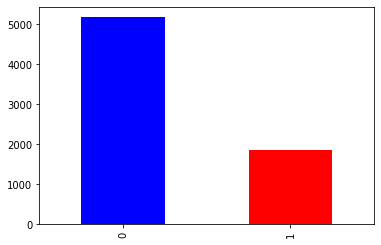

In [52]:
# Exibe a distribuição dos dados das variáveis depedendentes
df['Churn'].value_counts().plot.bar(color=['blue','red'])
df['Churn'].value_counts()

Nosso dataset possui um problema de balanceamento. Podemos observar atrvés do gráfico acima que somente 26,5% dos dados são de usuários que cancelaram o serviço. Isso significa que se o nosso modelo prever que nenhum usuário cancelou o serviço, a precisão do modelo é de 73,5%. Vamos voltar a este tópico posteriormente.

## 2 - Pré-processamento

In [6]:
# Transforma os dados categóricos do alvo y em dados numéricos
df['Churn'] = [0 if x == 'No' else 1 for x in df['Churn']]
df['Churn']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [7]:
# Separa a coluna de 'churn' do dataset
df_x = df.drop('Churn', axis=1)
df_y = df['Churn']

df_x.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [8]:
# Função que analisa os dados categóricos
def catergorias_unicas(df):
  for nome_coluna in df.columns:
    if df[nome_coluna].dtype == 'object':
      num_categorias_unicas = len(df[nome_coluna].unique())
      print(f"{nome_coluna} tem {num_categorias_unicas} categorias únicas")

catergorias_unicas(df_x)

gender tem 2 categorias únicas
Partner tem 2 categorias únicas
Dependents tem 2 categorias únicas
PhoneService tem 2 categorias únicas
MultipleLines tem 3 categorias únicas
InternetService tem 3 categorias únicas
OnlineSecurity tem 3 categorias únicas
OnlineBackup tem 3 categorias únicas
DeviceProtection tem 3 categorias únicas
TechSupport tem 3 categorias únicas
StreamingTV tem 3 categorias únicas
StreamingMovies tem 3 categorias únicas
Contract tem 3 categorias únicas
PaperlessBilling tem 2 categorias únicas
PaymentMethod tem 4 categorias únicas
TotalCharges tem 6531 categorias únicas


Ao passar pelo contador de categorias únicas, a feature 'TotalCharges' foi identificada como do tipo 'object', o que indica que essa coluna possui dados faltando.

In [9]:
# Substitui os dados faltando por 0.
x = df_x['TotalCharges']
x = x.replace({" ": 0})
x = pd.to_numeric(x)

x

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [10]:
df_x = df_x.drop('TotalCharges', axis=1)
df_x['TotalCharges'] = x

df_x['TotalCharges']

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [11]:
# A função get_dummies transforma os dados categóricos de uma coluna em novas colunas
to_dummy_list = ['gender', 'Partner', 'Dependents', 'PhoneService','MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

def to_dummy(df, to_dummy_list):
  for x in to_dummy_list:
    dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
    df = df.drop(x, axis=1)
    df = pd.concat([df, dummies], axis=1)
  return df

df_x = to_dummy(df_x, to_dummy_list)
df_x.head(5)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [12]:
# Verificando se nosso dataset ainda possui dados faltando
print(df.isnull().sum().sort_values(ascending=False).head())

gender            0
SeniorCitizen     0
TotalCharges      0
MonthlyCharges    0
PaymentMethod     0
dtype: int64


In [13]:
# Usando o algoritmo TukeyIQR para identificar outliers
import numpy as np

def find_ouliers_turkey(x):
  q1 = np.percentile(x,25)
  q3 = np.percentile(x,75)
  iqr = q3 - q1
  floor = q1 - 1.5*iqr
  ceiling = q3 + 1.5*iqr
  outlier_indicies = list(x.index[(x < floor) | (x > ceiling)])
  outlier_values = list(x[outlier_indicies])
  
  return outlier_indicies, outlier_values

outlier_indicies, outlier_values = find_ouliers_turkey(df_x['TotalCharges'])
print(outlier_values)

[]


In [14]:
outlier_indicies, outlier_values = find_ouliers_turkey(df_x['tenure'])
print(outlier_values)

[]


O identificador de outliers procura por dados que se afstem muito dos valores médios, para evitar que estes prejudiquem nosso modelo.

In [24]:
# Agora dividimos o dataset em conjuntos de treino, teste e validação.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.30, random_state=5, stratify=df_y)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.5, random_state=2, stratify=y_test)

Ao dividirmos o dataset, precisamos nos atentar novamente ao problema de desabalanceamento, nosso conjunto de validação precisa ser representativo do conjunto de teste. Para isso serve o parâmetro 'stratify', ele vai garantir que a proporção dos dados seja mantida. 

In [53]:
y_validation.value_counts() / y_validation.shape[0]

0    0.734153
1    0.265847
Name: Churn, dtype: float64

## 3 - Escolha das features

In [25]:
# Seleciona as features que melhor se relacionam com o churn
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=20)
selected_features = select.fit(x_train, y_train)
indicies_selected = selected_features.get_support(indices=True)
colnames_selected = [df_x.columns[i] for i in indicies_selected]

x_train = x_train[colnames_selected]
x_test = x_test[colnames_selected]
x_validation = x_validation[colnames_selected]

print(colnames_selected)

['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'TechSupport_No', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'Contract_Month-to-month', 'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'PaymentMethod_Electronic check']


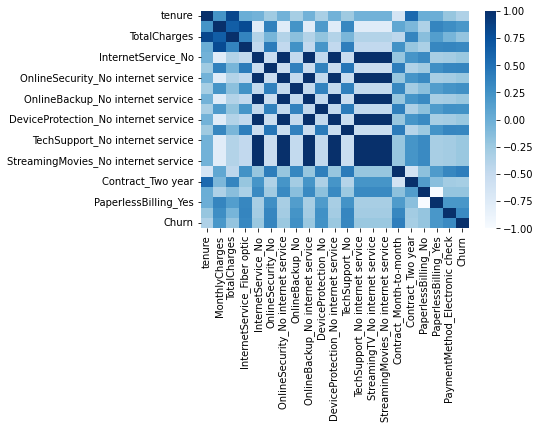

<Figure size 1008x576 with 0 Axes>

In [26]:
# heatmap que exibe relação entre as features selecionadas e o churn
import matplotlib.pyplot as plt
import seaborn 

x_train['Churn'] = y_train
seaborn.heatmap(x_train.corr(),
            cmap='Blues')
plt.show()

In [27]:
x_train = x_train.drop('Churn', axis=1)
x_train

,tenure,MonthlyCharges,TotalCharges,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineBackup_No,OnlineBackup_No internet service,DeviceProtection_No,DeviceProtection_No internet service,TechSupport_No,TechSupport_No internet service,StreamingTV_No internet service,StreamingMovies_No internet service,Contract_Month-to-month,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Electronic check
5974,10,20.05,218.50,0,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,0
2954,7,75.45,480.75,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
1329,72,19.40,1496.45,0,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0
1549,1,45.85,45.85,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
4377,22,80.00,1706.45,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792,15,48.85,736.80,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1
6881,32,35.15,1051.05,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1
2906,6,48.80,297.35,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0
2823,39,20.45,790.00,0,1,0,1,0,1,0,1,0,1,1,1,0,1,0,1,0


##4 - Normalização


In [ ]:
# Normalizando os dados
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)

In [29]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validation = scaler.transform(x_validation)

x_train[0]

array([0.13888889, 0.01645885, 0.0251589 , 0.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 1.        , 1.        , 1.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ])

A normalização de dados transforma todas as entradas em uma mesma escala, neste caso, valores entre 0 e 1. 

In [30]:
# lidando com o desbalanceamento de dados no conjunto de treino
from imblearn.over_sampling import RandomOverSampler

res = RandomOverSampler(random_state=42)
x_train_res, y_train_res = res.fit_resample(x_train, y_train)

x_train_res.shape

(7244, 20)

Para lidar com o desbalanceamento dos dados, podemos utilizar duas técnicas: oversampling e undersampling. Escolhi utilizar oversampling, pois obtive melhor resultados com este método. A lógica por trás dos algoritmos é simples, o oversampling cria novas colunas baseando-se nas já existentes, enquanto que a undersampling exclue colunas. No fim, ambas garantem que o conjunto de dados seja balanceado, com 50% de entradas de usuários que cancelaram o serviço e 50% de usuários que não cancelaram. 

## 5 - Calibrando os hiperparâmetros

In [31]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [32]:
def create_model(optimizer='adam'):
    ann = Sequential()
    ann.add(Dense(units=16, input_dim=20, activation='relu'))
    ann.add(Dense(units=16, activation='relu'))
    ann.add(Dense(units=1, activation='sigmoid'))
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

In [ ]:
# criando modelo temporário para grid search
classifier = KerasClassifier(build_fn=create_model, verbose=2)

In [34]:
# define os parâmetros do grid search
optimizer = ['SGD', 'Adam']
batch_size = [32, 64, 128]
epochs = [80, 90, 100, 110, 120]
param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=classifier, param_grid=param_grid, n_jobs=None, cv=5)
grid_result = grid.fit(x_train_res, y_train_res)

A saída de streaming foi truncada nas últimas 5000 linhas.
46/46 - 1s - loss: 0.6604 - accuracy: 0.6175 - 1s/epoch - 26ms/step
Epoch 2/100
46/46 - 0s - loss: 0.5583 - accuracy: 0.7369 - 99ms/epoch - 2ms/step
Epoch 3/100
46/46 - 0s - loss: 0.5076 - accuracy: 0.7585 - 88ms/epoch - 2ms/step
Epoch 4/100
46/46 - 0s - loss: 0.4838 - accuracy: 0.7676 - 89ms/epoch - 2ms/step
Epoch 5/100
46/46 - 0s - loss: 0.4732 - accuracy: 0.7726 - 103ms/epoch - 2ms/step
Epoch 6/100
46/46 - 0s - loss: 0.4684 - accuracy: 0.7757 - 96ms/epoch - 2ms/step
Epoch 7/100
46/46 - 0s - loss: 0.4661 - accuracy: 0.7771 - 91ms/epoch - 2ms/step
Epoch 8/100
46/46 - 0s - loss: 0.4647 - accuracy: 0.7766 - 104ms/epoch - 2ms/step
Epoch 9/100
46/46 - 0s - loss: 0.4635 - accuracy: 0.7773 - 108ms/epoch - 2ms/step
Epoch 10/100
46/46 - 0s - loss: 0.4625 - accuracy: 0.7778 - 85ms/epoch - 2ms/step
Epoch 11/100
46/46 - 0s - loss: 0.4618 - accuracy: 0.7788 - 101ms/epoch - 2ms/step
Epoch 12/100
46/46 - 0s - loss: 0.4609 - accuracy: 0.7786

In [ ]:
# exibe resultados do grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.730528 using {'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}
0.720721 (0.050409) with: {'batch_size': 32, 'epochs': 80, 'optimizer': 'SGD'}
0.716858 (0.044401) with: {'batch_size': 32, 'epochs': 80, 'optimizer': 'Adam'}
0.705811 (0.056954) with: {'batch_size': 32, 'epochs': 90, 'optimizer': 'SGD'}
0.710919 (0.054359) with: {'batch_size': 32, 'epochs': 90, 'optimizer': 'Adam'}
0.721554 (0.042070) with: {'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}
0.730528 (0.036195) with: {'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}
0.725010 (0.026198) with: {'batch_size': 32, 'epochs': 110, 'optimizer': 'SGD'}
0.719898 (0.038894) with: {'batch_size': 32, 'epochs': 110, 'optimizer': 'Adam'}
0.718109 (0.028253) with: {'batch_size': 32, 'epochs': 120, 'optimizer': 'SGD'}
0.713404 (0.057759) with: {'batch_size': 32, 'epochs': 120, 'optimizer': 'Adam'}
0.719757 (0.045733) with: {'batch_size': 64, 'epochs': 80, 'optimizer': 'SGD'}
0.727356 (0.023932) with: {'batch_size': 64,

O grid search é uma "mão na roda" no momento de determinar hiperparâmetros da rede. Basta criar um modelo e dizer quais parâmetros você deseja que ele teste. Ele cria um ranking com os melhores resultados obtidos e quais parâmetros foram utilizados para tais resultados.

## 6 - Treinando o modelo

In [37]:
# Criando modelo com novos hiperparâmetros
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(16, input_dim=20, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [39]:
# Trinando modelo
model.fit(
    x_train_res, 
    y_train_res,
    batch_size=32,
    epochs=100,
    validation_data=(x_validation, y_validation),
)

Epoch 1/100
227/227 [==============================] - 3s 6ms/step - loss: 0.5475 - binary_accuracy: 0.7268 - val_loss: 0.4950 - val_binary_accuracy: 0.7483
Epoch 2/100
227/227 [==============================] - 1s 5ms/step - loss: 0.4921 - binary_accuracy: 0.7576 - val_loss: 0.4770 - val_binary_accuracy: 0.7616
Epoch 3/100
227/227 [==============================] - 1s 3ms/step - loss: 0.4844 - binary_accuracy: 0.7628 - val_loss: 0.5133 - val_binary_accuracy: 0.7465
Epoch 4/100
227/227 [==============================] - 1s 3ms/step - loss: 0.4817 - binary_accuracy: 0.7657 - val_loss: 0.4792 - val_binary_accuracy: 0.7720
Epoch 5/100
227/227 [==============================] - 1s 3ms/step - loss: 0.4811 - binary_accuracy: 0.7637 - val_loss: 0.4933 - val_binary_accuracy: 0.7606
Epoch 6/100
227/227 [==============================] - 1s 3ms/step - loss: 0.4791 - binary_accuracy: 0.7648 - val_loss: 0.5171 - val_binary_accuracy: 0.7540
Epoch 7/100
227/227 [==============================] - 1s 

## 7 - Resultados

In [40]:
# Retorna acurácia e loss para conjunto de teste
model.evaluate(x_test, y_test)

33/33 [==============================] - 0s 2ms/step - loss: 0.4946 - binary_accuracy: 0.7282


[0.4945721924304962, 0.7282196879386902]

In [41]:
# Prevê churn baseado no conjunto de teste
predictions = model.predict(x_test)

# Tranforma predições em 0 e 1
prediction_list = []
for i in predictions:
    if i>0.5:
        prediction_list.append(1)
    else:
        prediction_list.append(0)

33/33 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

           0       0.90      0.71      0.79       776
           1       0.49      0.78      0.60       280

    accuracy                           0.73      1056
   macro avg       0.69      0.74      0.70      1056
weighted avg       0.79      0.73      0.74      1056



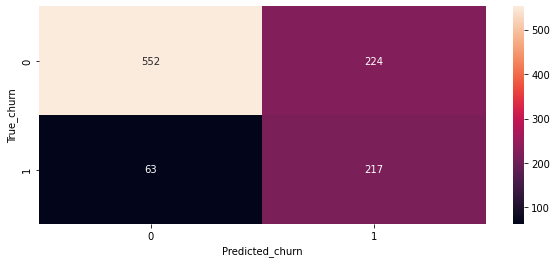

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sb

# imprime o classification report
print(classification_report(y_test, prediction_list))

# plota a confusion matrix
conf_mat = tf.math.confusion_matrix(labels=y_test,predictions=prediction_list)
plt.figure(figsize = (10,4))
sb.heatmap(conf_mat, annot=True,fmt='d')
plt.xlabel('Predicted_churn')
plt.ylabel('True_churn')
plt.show()

Nosso modelo obteve uma baixa precisão (49%) ao prever usuários que cancelaram o serviço, o que nos leva a crer que nosso modelo não serviu ao seu propósito, porém, quando olhamos para o recall, que é a medida entre total de valores reais e valores preditos, obtivemos 78% para os usuários que cancelaram o serviço. Na prática, isso significa que muitos usuários que não tendem a cancelar o serviço seriam classificados como usuários que tendem a cancelar, mas em contrapartida, poucos usuários que tendem a cancelar o serviço são classificados como usuários que não tendem a cancelar. Para fins de comparação, vamos testar o dataset de treino sem o oversample.

### Treinando modelo sem oversample

In [43]:
# Trinando modelo sem oversample
model.fit(
    x_train, 
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_validation, y_validation),
)

Epoch 1/100
155/155 [==============================] - 1s 3ms/step - loss: 0.4029 - binary_accuracy: 0.8114 - val_loss: 0.4475 - val_binary_accuracy: 0.7852
Epoch 2/100
155/155 [==============================] - 0s 3ms/step - loss: 0.3967 - binary_accuracy: 0.8099 - val_loss: 0.4514 - val_binary_accuracy: 0.7862
Epoch 3/100
155/155 [==============================] - 0s 3ms/step - loss: 0.3961 - binary_accuracy: 0.8146 - val_loss: 0.4484 - val_binary_accuracy: 0.7909
Epoch 4/100
155/155 [==============================] - 0s 3ms/step - loss: 0.3968 - binary_accuracy: 0.8126 - val_loss: 0.4475 - val_binary_accuracy: 0.7928
Epoch 5/100
155/155 [==============================] - 0s 3ms/step - loss: 0.3953 - binary_accuracy: 0.8172 - val_loss: 0.4563 - val_binary_accuracy: 0.7786
Epoch 6/100
155/155 [==============================] - 0s 3ms/step - loss: 0.3958 - binary_accuracy: 0.8118 - val_loss: 0.4593 - val_binary_accuracy: 0.7796
Epoch 7/100
155/155 [==============================] - 0s 

In [44]:
# Retorna acurácia e loss para conjunto de teste
model.evaluate(x_test, y_test)

33/33 [==============================] - 0s 2ms/step - loss: 0.4304 - binary_accuracy: 0.7888


[0.43039318919181824, 0.7888257503509521]

In [45]:
# Prevê churn baseado no conjunto de teste
predictions = model.predict(x_test)

# Tranforma predições em 0 e 1
prediction_list = []
for i in predictions:
    if i>0.5:
        prediction_list.append(1)
    else:
        prediction_list.append(0)

33/33 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

           0       0.82      0.91      0.86       776
           1       0.64      0.46      0.54       280

    accuracy                           0.79      1056
   macro avg       0.73      0.68      0.70      1056
weighted avg       0.78      0.79      0.78      1056



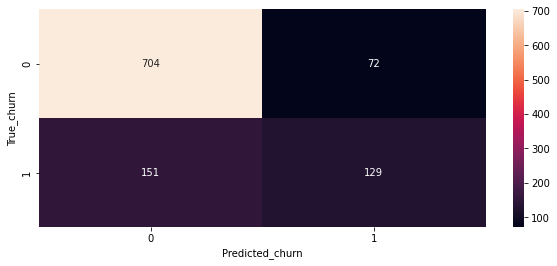

In [46]:
# imprime o classification report
print(classification_report(y_test, prediction_list))

# plota a confusion matrix
conf_mat = tf.math.confusion_matrix(labels=y_test,predictions=prediction_list)
plt.figure(figsize = (10,4))
sb.heatmap(conf_mat, annot=True,fmt='d')
plt.xlabel('Predicted_churn')
plt.ylabel('True_churn')
plt.show()

Observando os resultados, temos uma acurácia muito superior em relação ao modelo anterior, mas quando olhamos para o recall do modelo, é de apenas 46% para os usuários que cancelaram o serviço, uma queda drástica em relação ao modelo com oversampler. Mas na prática, qual modelo seria melhor? Acredito que isso iria depender de quais os seus objetivos com seu modelo. Por exemplo, se você é dono de uma empresa e quer reduzir o churn de clientes, gastando o mínimo possível, provavelmente o modelo que apresenta maior acurácia é a melhor opção. Todavia, se você quer reduzir ao máximo o churn de clientes, o modelo de maior recall seria a escolha mais provável. Em resumo, ambos os modelos tem suas aplicações, considerando as diferentes situações em que são utilizados.